<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Handwritten Digit Recognition with Artificial Neural Networks (ANNs)

**Handwritten digit recognition** is a classic task in machine learning where the goal is to develop algorithms that can accurately interpret and classify images of handwritten digits (typically 0 through 9). A well-known benchmark dataset for this task is the MNIST dataset, which contains thousands of labeled examples of handwritten digits written by different people. The challenge lies in enabling computers to recognize the variability in individual handwriting styles, sizes, and shapes, despite distortions, noise, or inconsistencies in the input images. This task typically involves techniques such as image preprocessing, feature extraction, and the application of machine learning models like neural networks, support vector machines, or more recently, deep learning models such as convolutional neural networks (CNNs).

Handwritten digit recognition is important because it serves as a foundational problem in the broader field of pattern recognition and computer vision. Solving this problem effectively demonstrates the potential of machines to interpret and process human-generated data, paving the way for more complex tasks like automatic document processing, check verification in banks, and digitizing handwritten forms. Beyond its practical applications, it is also a widely used educational tool and benchmark to evaluate and compare machine learning algorithms, helping researchers refine techniques that are later adapted for more advanced problems in image classification, natural language processing, and artificial intelligence.

The **MNIST dataset** (Modified National Institute of Standards and Technology dataset) is a large collection of handwritten digits that is widely used as a benchmark for evaluating machine learning models, especially in the field of image classification. It consists of 70,000 grayscale images of handwritten digits &mdash; 60,000 images in the training set and 10,000 in the test set &mdash; with each image being a 28$\times$28 pixel square. Each image is labeled with the correct digit it represents (0 through 9), making it a supervised learning dataset. The dataset was created by modifying and combining samples from the original NIST datasets, which contained handwriting from American Census Bureau employees and high school students, to create a more standardized and accessible resource for machine learning research.

MNIST gained popularity because it is relatively small and simple, making it an ideal starting point for testing and validating new image recognition algorithms. Despite its simplicity, it captures enough variability in handwriting to present a meaningful challenge, allowing researchers and practitioners to experiment with preprocessing methods, feature extraction, and different classification algorithms. Over time, MNIST has become a standard benchmark for assessing the performance of models like logistic regression, support vector machines, and convolutional neural networks, and it has played a significant role in advancing developments in computer vision and deep learning.

In this notebook, we address the task of handwritten digit recognition using basic Artificial Neural Networks (ANNs). We will see that even a small ANN will yield good results, and we will discuss at the end why this task does not necessarily require more sophisticated neural network architectures such as Convolutional Neural Networks (CNNs).

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
from src.utils.libimports.mnistann import *
from src.utils.data.files import *
from src.utils.compute.gpu import *
from src.utils.plotting.nn import *

#### Download MNIST Dataset

You can download the MNIST dataset as a '.zip' archive file by running the code cell below. If this code cell throws any error, please check the configuration file `config.yaml` if the URL for downloading datasets is up to date and matches the one on Github. If not, simply download or pull the latest version from Github.

In [2]:
mnist_zip, mnist_folder = download_dataset("images/classification/mnist/mnist.zip")

print(f"mnist.zip downloaded into folder {mnist_folder}")

100%|█████████████████████████████████████| 11.6M/11.6M [00:00<00:00, 18.6MiB/s]

mnist.zip downloaded into folder data/datasets/images/classification/mnist/


Running the code cell below extracts the `.zip` archive into the four dataset files &mdash; two for the training data and two for the test data. You can change the variable `mnist_folder` to change the folder into which the extracted files are placed; by default the files are placed into the same folder as the `.zip` file.

In [3]:
#mnist_folder = "/path/to/file/location/"

decompress_file(mnist_zip, target_path=mnist_folder)

#### Checking & Setting Computing Device

PyTorch allows to train neural networks on supported GPU to significantly speed up the training process. If you have a support GPU, feel free to utilize it. However, for this notebook it's certainly not needed as our dataset is small and our network model is very simple. We provide an auxiliary method to automatically select the best device. It checks if a supported GPU is available and if so, uses it as the preferred device.

In [4]:
# Select preferred device (GPU, if available; CPU otherwise); you can enfore the use of the CPU
device = select_device(force_cpu=False)

print("Available device: {}".format(device))

Available device: cuda:0


---

## Load & Prepare Dataset

Before we can train a model for handwritten digit recognition, we first have to load the training and test data and convert it into a suitable representation to serve as input for the model. This includes loading the data from files into an internal representation in memory, and utilizing auxiliary classes provided by the PyTorch library to streamline the training and evaluation. In the following, we go through these two main steps in more detail.

### Load Images & Labels

The MNIST dataset is stored in a special binary file format called IDX, which has a specific header structure. For the image files (like `train-images.idx3-ubyte`), the first 16 bytes form the header that describes the metadata of the dataset. Here’s a breakdown of those first 16 bytes:

| Byte Offset | Length (bytes) | Description                                                |
|-------------|----------------|------------------------------------------------------------|
| 0           | 4              | **Magic number** (0x00000803) — identifies the file type as a set of images |
| 4           | 4              | **Number of images** (e.g., 60,000 for training set)       |
| 8           | 4              | **Number of rows** (28)                                    |
| 12          | 4              | **Number of columns** (28)          

In more detail:
* **Bytes 0-3:** Magic number = 0x00000803 (2051 in decimal, which means this is an image file)
* **Bytes 4-7:** Number of images (e.g., 60,000 or 10,000)
* **Bytes 8-11:** Number of rows per image (28)
* **Bytes 12-15:** Number of columns per image (28)

After these 16 bytes, the actual image pixel data starts &mdash; where each pixel is stored as an unsigned byte (0 to 255).

The method `load_mnist_images()` below reads an IDX image file of the MNIST dataset. The [`frombuffer()`](https://numpy.org/doc/stable/reference/generated/numpy.frombuffer.html) method of the NumPy library interprets a buffer (like a byte string or bytearray) as a 1-dimensional NumPy array without copying the data. It allows to quickly convert raw binary data into a NumPy array by specifying the desired data type (`dtype`). Since each pixel is stored as an unsigned byte (0 to 255), we can use `uint8` as the data type. Also notice the `offset=16` which conveniently allows to skip the first 16 bytes of the header

The `frombuffer()` method returns a long 1d array containing the pixel values for all images. The method `load_mnist_images()` therefore reshapes this 1d array into a 2d array where the rows (i.e., 1st dimension) reflects the number of images and the columns (i.e., 2nd dimension) reflects the number of pixels per image (i.e., 28$\times$28=784).

In [5]:
def load_mnist_images(path):
    with open(path, "rb") as f:
        # First 16 bytes are magic number, n_imgages, n_rows, n_columns
        pixels = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    # Reshape array into (n_images, n_pixels_per_image) and return
    return pixels.reshape(-1, 784)

With this method we can now load the images of the training and the test dataset. Note that this dataset is not very large, so there is no problem holding all images in memory.

In [6]:
images_train = load_mnist_images(mnist_folder+"train-images.idx3-ubyte")
images_test  = load_mnist_images(mnist_folder+"t10k-images.idx3-ubyte")

print(f"Shape (n_images, n_pixels) of training data: {images_train.shape}")
print(f"Shape (n_images, n_pixels) of test data: {images_test.shape}")

Shape (n_images, n_pixels) of training data: (60000, 784)
Shape (n_images, n_pixels) of test data: (10000, 784)


For the training and the valuation we also need the ground-truth labels which are stored in two separate files. For the label files in the MNIST dataset (like train-labels-idx1-ubyte), the first 8 bytes form the header that describes the dataset metadata. Here’s the breakdown of those first 8 bytes:

| Byte Offset | Length (bytes) | Description                                                |
|-------------|----------------|------------------------------------------------------------|
| 0           | 4              | **Magic number** (0x00000801) — identifies the file type as labels |
| 4           | 4              | **Number of labels** (e.g., 60,000 for training set)       |

In more detail:
* **Bytes 0-3:** Magic number = 0x00000801 (2049 in decimal — means this is a label file)
* **Bytes 4-7:** Number of labels (e.g., 60000 or 10000)

After these 8 bytes, the actual label data starts &mdash; each label is stored as a single unsigned byte (representing the digit 0–9). Again, let's define a simple method `load_mnist_labels()` to read the label files and store all labels as NumPy array.

In [7]:
def load_mnist_labels(path):
    with open(path, "rb") as f:
        # First 8 bytes are magic_number, n_images
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return labels

We can now call method `load_mnist_labels()` twice to load the labels of the training and the test dataset.

In [8]:
labels_train = load_mnist_labels(mnist_folder+"train-labels.idx1-ubyte")
labels_test  = load_mnist_labels(mnist_folder+"t10k-labels.idx1-ubyte")

print(f"Shape (n_images, n_pixels) of training labels: {labels_train.shape}")
print(f"Shape (n_images, n_pixels) of test labels: {labels_test.shape}")

Shape (n_images, n_pixels) of training labels: (60000,)
Shape (n_images, n_pixels) of test labels: (10000,)


Before we continue, let's have a quick look at some example images. The code cell below plots the first $k$ handwritten digits of the test dataset. For a better visualization the images are plotted in a grid with `n_row` rows and `n_cols` columns. Thus, for the default values `n_row, n_col = 3, 5`, the number of shown images is $k=15$. You can change the values of `n_row` and `n_cols` to see more or less example images.

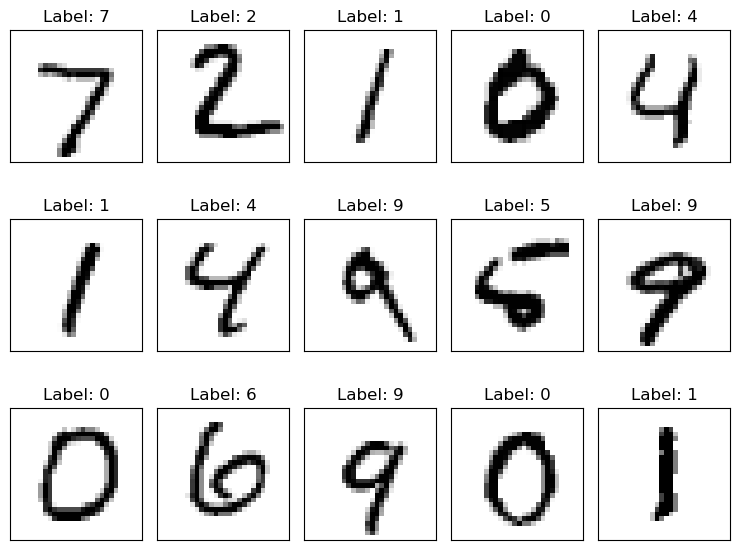

In [9]:
n_row, n_col = 3, 5

fig, axes = plt.subplots(n_row, n_col, figsize=(1.5*n_col,2*n_row))
for i in range(n_row*n_col):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images_test[i].reshape(28,28), cmap='gray_r')
    ax.set_title('Label: {}'.format(labels_test[i]))
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.show()

A very important observation is that the MNIST dataset (and similar datasets containing hand-written digits) contains **size-normalized** and **centered** digits in **fixed-size images** &mdash; more specifically:

* **Size-normalized:** Each handwritten digit has been scaled so that its shape roughly fits within a standard size, regardless of how large or small the original handwritten digit was. This means tall, narrow, short, or wide digits are all resized to be comparable in scale, which reduces variability caused by different handwriting styles.

* **Centered in fixed-size images:** Every digit is placed in the middle of a 28$\times$28 pixel image. The image size is fixed &mdash; that is, all images have exactly the same dimensions. The digit itself is centered within the image so that it does not touch the edges and is consistently located, making it easier for machine learning models to learn relevant patterns without worrying about positional shifts.

This preprocessing step helps ensure that the variation in the dataset comes mainly from handwriting style rather than inconsistencies in size or position, which simplifies the task for machine learning models and is eventually the reason why more sophisticated neural network architectures such as CNNs are not required to address this task of handwritten digit recognition.

### Generate `Dataset` & `DataLoader`

So far, we have both the images and labels stored as NumPy arrays. To train an Artificial Neural Network (ANN) using, here, the PyTorch library, we first need to convert the NumPy arrays into PyTorch tensors. Using the `Tensor` and `LongTensor` class of PyTorch, this is very easy to do, as shown in the code cell below.

Notice that we use the `Tensor` class for the images. Although the pixel values are integer values ranging from 0 to 255, our model expects the input values of type float; the `Tensor` class automatically converts the integer values to float values. In contrast, the labels are indeed treated as integers, hence the use of the `LongTensor` class.

In [10]:
X_train = torch.Tensor(images_train.copy())
y_train = torch.LongTensor(labels_train.copy())

X_test = torch.Tensor(images_test.copy())
y_test = torch.LongTensor(labels_test.copy())

For convenience, it is also a best practice to create an implementation of the PyTorch `Dataset` class. The `TensorDataset` class in the PyTorch library is a simple dataset wrapper that allows combining multiple tensors into a single dataset object. Each sample in the dataset is a tuple where the *n*-th element comes from the *n*-th tensor provided. Typically, this is used to pair input data (like images or features) with corresponding labels, making it easy to iterate over batches of data and labels together during training or evaluation. All tensors passed to `TensorDataset` must have the same first dimension (i.e., the same number of samples).

`TensorDataset` is particularly useful when you already have your data loaded as PyTorch tensors &mdash; which we have &mdash; and want a quick way to feed them into a DataLoader for batching, shuffling, and parallel loading. It provides a minimal and clean interface, especially for small to medium-sized datasets or prototyping, without needing to define a full custom dataset class. So let's create a `TensorDataset` for both the training and test data.

In [11]:
dataset_train = TensorDataset(X_train, y_train)
dataset_test  = TensorDataset(X_test,  y_test)

The last step is to create `DataLoader` instances for the training and test dataset. The `DataLoader` class in PyTorch is a utility that provides an efficient way to load data in batches from a dataset (such as a `TensorDataset` or a custom dataset). It handles tasks like batching the data, shuffling the dataset, and loading data in parallel using multiple worker processes. By wrapping a dataset in a `DataLoader`, you can easily iterate over mini-batches of your data during training or evaluation, which is essential for efficiently training models using stochastic gradient descent and other optimization algorithms.

The main benefits of `DataLoader` include automatic batching (to process multiple samples at once), shuffling (to help models generalize better), and parallel data loading (to speed up data access using multiple CPU cores). It also supports customizable sampling strategies and can handle variable-length data through custom collate functions. Overall, `DataLoader` streamlines the data management process, making it much easier and faster to feed data into your models, especially when working with large datasets.

In [12]:
loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
loader_test  = DataLoader(dataset_test,  batch_size=64)

Notice that we shuffle the training dataset so that the data samples are shuffled before forming a mini-batch for the next training epoch. Shuffling the training data into different mini-batches between epochs is beneficial because it helps prevent the model from learning spurious patterns related to the order of the data rather than the actual underlying relationships in the dataset. If data is always fed to the model in the same sequence, the model might overfit to that specific order, which can reduce its ability to generalize to unseen data. Shuffling ensures that each mini-batch is varied from epoch to epoch, encouraging the model to be robust to the ordering and distribution of samples.

Another important benefit is that shuffling helps break up potential correlations between consecutive samples that might bias the gradient updates during training. For example, if similar samples are grouped together in the dataset (like many examples of the same digit in a row in MNIST), feeding them consecutively could cause redundant or skewed updates to the model's parameters. By shuffling, each mini-batch becomes a more representative mix of the overall dataset, leading to more stable and effective gradient estimates, which often results in faster convergence and better generalization.

Overall, shuffling increases randomness and diversity in the batches the model sees across epochs, which can improve both training efficiency and model performance on test data. That is why, in practice, `shuffle=True` is often set in PyTorch's `DataLoader` during training, but not typically used during validation or testing (where consistent evaluation is more important).

---

## Create & Train Model

For creating and training the ANN model, we use open source machine learning framework PyTorch. PyTorch is convenient and easy for creating and training neural network models in Python because it uses a dynamic computation graph, meaning the graph is built on-the-fly as operations are executed, which aligns naturally with Python's imperative programming style and makes model development highly intuitive and flexible. Its syntax is clean and closely mirrors NumPy, reducing the learning curve for Python users, while the built-in autograd system simplifies gradient computation for backpropagation. Additionally, PyTorch offers a seamless GPU acceleration via CUDA, making both prototyping and large-scale training straightforward and efficient.

### Create ANN Model Architecture

The class `MnistANN` in the code cell implements a simple Artificial Neural Network (ANN) using PyTorch. The network consists of two hidden layers and one output layer. Both hidden layers use a Rectified Linear Unit (ReLU) as the activation function. The output layer is followed by a LogSoftmax function which fist calculates the Softmax and then applies the logarithm in a single function; in short:

$$\large
LogSoftmax(x) = \log{\left( Softmax(x) \right)}
$$

The advantage of using LogSoftmax instead of Softmax is numerical stability and computational efficiency when combined with loss functions like Negative Log-Likelihood Loss (NLLLoss) &mdash; see below &mdash; because it avoids very small probability values that can cause underflow. By working directly with log-probabilities, LogSoftmax simplifies the math in many cases (like log-likelihood computations) and reduces the risk of floating-point precision issues, making training more stable and gradients easier to compute accurately.

**Your turn:** Modify class `MnistANN` to make the network simpler or more complex (e.g., by removing or adding hidden layers) or replacing the ReLU activation function with other nonlinearities.

In [13]:
class MnistANN(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            #nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inputs):
        return self.model(inputs)

We can now create an instance of our model and move it to the preferred device (e.g., a GPU if available).

In [14]:
model = MnistANN().to(device)

print(model)

MnistANN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


With the model in place, we can now use the MNIST dataset to train the model to recognize handwritten digits.

### Model Training

#### Definition of Auxiliary Methods

For training the model, the code cell defines the auxiliary method `train_epoch()` that implements that basic training loop for a single epoch &mdash; the training of a model with respect to all training samples using mini-batches. In a nutshell, the method iterates through all data samples in a `DateLoader` instance and performs the following steps:
* Extract the next mini-batch of training samples from the data loader
* Move the mini-batch (all images and labels) to the same device running the model
* Give the mini-batch to the model as input and to get log probabilities as the model's output
* Calculate the mini-batch loss with respect to the ground-truth labels and the given loss function (see below)
* Perform backpropagation and update the model parameters (done by PyTorch under the hood)

During each iteration we accumulate and in the end return the overall loss for the epoch.

In [15]:
def train_epoch(model, loader, optimizer, criterion):
    # Initialize epoch loss (cummulative loss fo all batchs)
    epoch_loss = 0.0
    # Use tqdm to get a nice progress bar
    with tqdm(total=len(loader)) as pbar:
        # Iterate over all batches
        for X_batch, y_batch in loader:
            # Move the batch to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Get model outputs as log probabiltiies
            log_probs = model(X_batch)
            # Calculate loss
            loss = criterion(log_probs, y_batch)
            ### Pytorch magic! ###
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Keep track of overall epoch loss
            epoch_loss += loss.item()
            # Update progress bar
            pbar.update(1)
    # Return total loss across whole dataset
    return epoch_loss    

Although not required for the training itself, we want to monitor how the prediction performance of our model changes over time, i.e., after each epoch. To this end, the model below implements the auxiliary method `evaluate()` that iterates over all samples in a data loader, calculates the predicted labels using the given model, and returns the F1 score based on the predicted and ground-truth labels.

In [16]:
def evaluate(model, loader):
    # Define 2 lists holding all true labels and all predicted labels
    y_true, y_pred = [], []
    # Use tqdm to get a nice progress bar
    with tqdm(total=len(loader)) as pbar:
        # Iterate over all batches
        for X_batch, y_batch in loader:
            # Move the batch to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Get model outputs as log probabiltiies
            log_probs = model(X_batch)
            # Calculate predicted class labels based on largest log probability values
            y_batch_pred = torch.argmax(log_probs, dim=1)
            # Add the true labels and predicted labels for batch ot final lists
            y_true += list(y_batch.cpu())
            y_pred += list(y_batch_pred.cpu())
            # Update progress bar
            pbar.update(1)
    # Return f1 score
    return f1_score(y_true, y_pred, average='macro')

Let's evaluate our currently untrained model on the test data by calling method `evaluate()` and the data loader holding the test data.

In [17]:
f1 = evaluate(model, loader_test)

print(f"F1 score: {f1:.3f}")

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 417.15it/s]


F1 score: 0.041


While the exact result will different depending on the random initialization of the model parameters, the f1 score of the untrained model should roughly be around $0.1$. This is because our untrained model is more less just guessing, and given that we have 10 possible classes (0, 1, 2, ..., 9), the model will be correct about 10% of the time.

#### Definition of Loss Function and Optimizer

To train the model using backpropagation and parameter updates, we need to define two more components:
* **Loss function (or *criterion*):** The loss function measures how far the neural network's predictions are from the actual correct answers (i.e., the ground-truth labels). A loss function is sometimes called a criterion &mdash; and this term is commonly used in PyTorch &mdash; because it serves as the "standard" or "rule" by which the model’s performance is judged. Since our model returns log probabilities &mdash; recall that out model uses the LogSoftmax instead of the Softmax function &mdash; the suitable criterion is the Negative Log-Likelihood Loss (NLLLoss), which of course is provided by PyTorch.
* **Optimizer:** After calculating the gradients for all model parameters with respect to the loss, the optimizer is responsible for the actual update of the model parameters based on the calculated gradients. There are different strategies and hence different optimizers available. In this code cell below, we use the *Adam* optimizer. The Adam optimizer is a method for updating a neural network's weights that combines different ideas to make learning faster and more stable; it adjusts the learning rate for each weight automatically by keeping track of both the average of past gradients and how much those gradients have varied. This makes Adam work better than standard Gradient Descent because it can handle noisy data, works well with sparse features, and needs less fine-tuning of the learning rate, helping the model learn faster and more reliably.

In [18]:
# Define loss function
criterion = nn.NLLLoss()
# Define optimizer for the update step
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#### Training Loop

Using the our two auxiliary methods `train_epoch()` and `evaluate()` training the model for several epochs (here: 10) &mdash; and evaluating the model after each epoch &mdash; becomes very simple, as shown in the code cell below. The only additional things to mention are the two calls `model.train()` and `model.eval()`. In PyTorch, the `train()` method sets the model to training mode, which turns on behaviors like dropout and batch normalization updates that help the model learn better during training, while the `eval()` method sets the model to evaluation mode, which turns off those behaviors so that the model makes stable, consistent predictions when testing or using it in real life; switching between them ensures the model behaves correctly in both training and testing situations.

Although the model does not contain any component (e.g., dropout or batch normalization), it is a good practice to switch between the training and evaluation mode appropriately. With this, we could change our model, for example, by including one or more dropout layers without the need to change the training loop in the code cell below. So run the code cell to train the model for `num_epochs` epochs. You can run the code cell multiple times to continue the training if needed.

In [19]:
num_epochs = 10
results = []

for epoch in range(1, num_epochs+1):
    # Set model into training mode
    model.train()
    # Train model for a single epch
    epoch_loss = train_epoch(model, loader_train, optimizer, criterion)
    # Set model into evaluation mode
    model.eval()
    # Calculate training and test f1 scores
    f1_train = evaluate(model, loader_train)
    f1_test = evaluate(model, loader_test)
    # Append the epoch loss, training f1 score, and test f1 score to final result list (for plotting later)
    results.append((epoch_loss, f1_train, f1_test))
    # Print progress(epoch loss, training f1 score, and test f1 score)
    print(f"[Epoch {epoch}] loss:\t{epoch_loss:.3f}, f1 train: {f1_train:.3f}, f1 test: {f1_test:.3f}")  

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 591.41it/s]


[Epoch 1] loss:	1436.254, f1 train: 0.919, f1 test: 0.911


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 589.31it/s]


[Epoch 2] loss:	325.271, f1 train: 0.946, f1 test: 0.932


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 590.36it/s]


[Epoch 3] loss:	192.427, f1 train: 0.961, f1 test: 0.945


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 589.79it/s]


[Epoch 4] loss:	133.369, f1 train: 0.972, f1 test: 0.953


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 592.39it/s]


[Epoch 5] loss:	94.572, f1 train: 0.977, f1 test: 0.953


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 589.23it/s]


[Epoch 6] loss:	72.514, f1 train: 0.983, f1 test: 0.957


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 589.04it/s]


[Epoch 7] loss:	57.083, f1 train: 0.986, f1 test: 0.958


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 588.84it/s]


[Epoch 8] loss:	47.362, f1 train: 0.990, f1 test: 0.964


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 591.82it/s]


[Epoch 9] loss:	33.170, f1 train: 0.992, f1 test: 0.963


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 366.78it/s]


[Epoch 10] loss:	28.218, f1 train: 0.993, f1 test: 0.965


Even when starting from an untrained model, you should see that the model already achieves an F1 score of about $0.9$ after the first epoch, and then only improves slightly more over time. This is because the task is a relatively easy one even for a simple ANN, as we will discuss more at the end. Since we keep track of the loss as well as the F1 scores regarding the training and the test data, we can also plot the results use the auxiliary method `plot_training_results()` we provide.

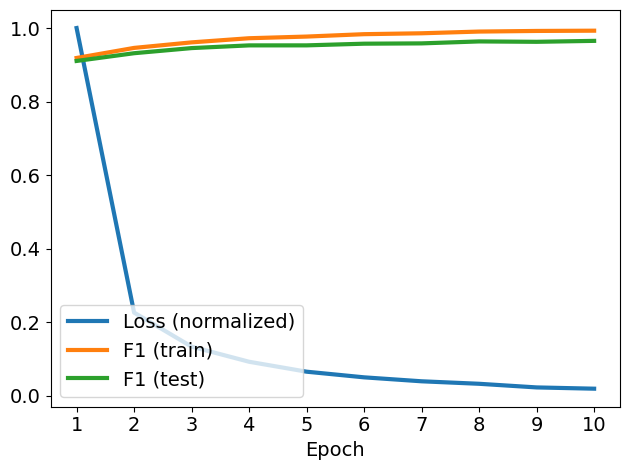

In [20]:
plot_training_results(results, legend=['Loss (normalized)', 'F1 (train)', 'F1 (test)'])

### Making Predictions

Of course, in practice, we want to use our trained model to make predictions for a given input image or batch of input images. Let's implement a simple method `predict()` that passes and input batch to the model, calculates the log probabilities for each image in the batch, and returns the predicted class label for each image.

In [21]:
def predict(model, batch):
    # Pass batch to model to get log probabilities
    log_probs = model(batch)
    # Return predictions derived from the largest log probabilities
    return torch.argmax(log_probs, dim=1)

To show an example, let use the method to predict the class labels of the first *k* images in our test dataset &mdash; that is, the same *k* images we have plotted at the beginning of the notebook (see above); hence the use of `n_col` and `n_row` and have previously defined.

In [22]:
# Create batch from the first k images of the test set
batch_pred = predict(model, X_test[:n_col*n_row].to(device)).cpu()
# Organize the predicted class label to match the grid layout from above
batch_pred = batch_pred.reshape(n_row, n_col)
# Print predicted class labels
print(batch_pred)

tensor([[7, 2, 1, 0, 4],
        [1, 4, 9, 5, 9],
        [0, 6, 9, 0, 1]])


If you compare the output with the grid of image plots above, you will notice that they match &mdash; that is, for example, the first entry is a $7$, matching the first image plot showing a $7$ in the grid. Since our model is not perfect, there is the possibility that one or two of the predictions do not match up due to misclassifications. However, since we got an F1 score of more $0.95$ most or all of the predictions are likely to be correct.

---

## Error Analysis

Although our model seems to work reasonably well, it is of course not perfect as it misclassified some images from the test dataset. Let's therefore have a closer look at what images of handwritten digits our model recognized incorrectly. **Error analysis** in machine learning is the process of carefully studying the mistakes a model makes &mdash; looking at the cases where it gets predictions wrong &mdash; to understand why those errors happen. By examining these incorrect predictions, you can find patterns, such as certain types of inputs the model struggles with or parts of the data that are confusing or mislabeled.

The goal of error analysis is to get insights that help improve the model, whether by fixing data problems, adjusting the model, or changing how you train it. It's a way to make smarter decisions about what to fix next, instead of just blindly trying random improvements. While further improvements are beyond the scope of this notebook, we can still look at some mistakes of our model to get some ideas of its weaknesses. For this, we simply iterate again through all the samples in our test dataset and keep track of the true and predicted class labels for each image.

In [23]:
y_true, y_pred = [], []

# Use tqdm to get a nice progress bar
with tqdm(total=len(loader_test)) as pbar:
    # Iterate over all batches
    for idx, (X_batch, y_batch) in enumerate(loader_test):
        # Move the batch to the correct device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Get model outputs as log probabiltiies
        log_probs = model(X_batch)
        # Calculate predicted class labels based on largest log probability values
        y_batch_pred = torch.argmax(log_probs, dim=1)
        # Add the true labels and predicted labels for batch ot final lists
        y_true += list(y_batch.cpu())
        y_pred += list(y_batch_pred.cpu())
        # Update progress bar
        pbar.update(1)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 538.11it/s]


Using the code below, we can not find all misclassifications by finding the indices in the arrays `y_true` and `y_pred` where the values in both arrays differ. The `equal()` method in Numpy compares two arrays element by element and returns a new array of `True` or `False` values, showing where the elements are exactly the same. Since we are interested in the values that are not the same, we can flip the Boolean values in the array using `~`. We then also cast the Boolean area into an integer array where all `False` values become $0$ and all `True` values become $1$. Lastly, `flatnonzero()` method returns the indices of all the non-zero elements in an array. After all, we do not care about the predictions our model got right.

In [24]:
# Find all misclassifications (and correct classifications)
mismatch = (~np.equal(y_true, y_pred)).astype(int)
# Extract the indices of all misclassifications
indices_misclassifications = np.flatnonzero(mismatch)
# Print the number of misclassifications
print(f"Number of misclassifications: {indices_misclassifications.shape}")

Number of misclassifications: (347,)


Again, the exact number of misclassifications will depend on the initialization of the model parameters, the choice of the optimizer (and its parameters) as well as the number of epochs the model has been trained. However, you are likely to see between 300-600 misclassifications, out of a total of 10,000 training samples.

Using the indices of all misclassifications, we can now create a subset of the test dataset that only contains the samples that yield a misclassification.

In [25]:
X_misclassifications = X_test[indices_misclassifications]
y_misclassifications = y_test[indices_misclassifications]

We can now use the same code brom before to plot the first *k* images, however, now only from the dataset of misclassifications. The label above each image shows both the true label and the predicted label.

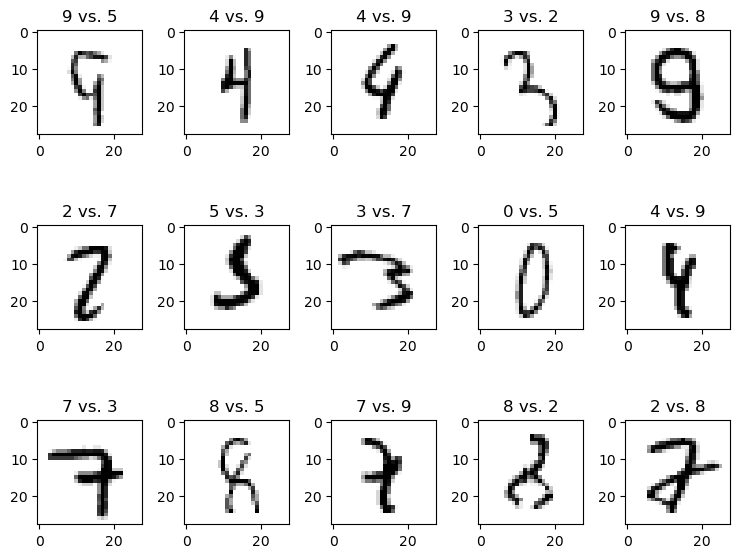

In [26]:
fig, axes = plt.subplots(n_row, n_col, figsize=(1.5*n_col,2*n_row))
for i in range(n_row*n_col):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(X_misclassifications[i].reshape(28,28), cmap='gray_r')
    log_probs = model(X_misclassifications[i].reshape(1,-1).to(device))
    label_pred = torch.argmax(log_probs, dim=1).cpu().item()
    label_true = y_misclassifications[i].cpu().item()
    ax.set_title(f"{label_true} vs. {label_pred}")
plt.tight_layout()
plt.show()

When looking at the examples above, you are likely to see cases where it is rather easy why the model has made a wrong prediction. For example, a "sloppy" $2$ (with only a small bottom part) can be mistaken for a $7$. On the other hand, you are also likely to see some cases where the digit is generally properly written but the model still recognizes it as a different digit. These cases highlight why understanding how a trained model works is both important and challenging. For example, if two very similar-looking images return different predictions, it may mean that the model is rather "brittle" &mdash; just small changes to the input can quickly alter the predicted output. But again, a deeper discussion is beyond the scope of this notebook.

---

## Discussion

In this notebook we addressed the task of handwritten digit recognition using a simple artificial neural network (ANN), and saw that the model performed arguably quite well. One might therefore wonder why ANNs are generally not used for similar image classification tasks. The answer to this question lies in the simple nature of the dataset in terms of the variety of the training samples.

It is important that MNIST images are size-normalized and centered when using simple neural networks (fully connected networks, i.e., ANNs) because these networks do not naturally understand the spatial structure of images. A fully connected neural network treats the image as just a long list of numbers (e.g., 784 pixel values), without knowing which pixels are near each other or where features like edges and curves are located. If the digit is off-center or varies too much in size, the same number might produce very different patterns of pixel values, making it harder for the network to learn consistent patterns.

* **Size-normalizing** the digits makes sure that all the handwritten numbers are roughly the same scale. This means, for example, that a small "5" does not get confused with noise or looks completely different from a large "5". When the size is consistent, the neural network sees more similar pixel patterns for the same digit across many examples, which helps it learn more effectively.

* **Centering** the digits means aligning them so they sit roughly in the middle of the image, which reduces variation in where the important features (like loops or lines) appear within the pixel grid. If the same digit appears in different corners of the image, a simple neural network (which has no idea about "position") will struggle to recognize them as the same digit. Centering helps ensure that, no matter who wrote the digit, it shows up in the same general spot, again making it easier for the model to learn.

In contrast, **Convolutional Neural Networks (CNNs)** are much better at handling shifts, scale changes, and spatial patterns because they process images in small patches and can recognize patterns no matter where they appear. But in simple ANNs, we need to help the model by making the images as uniform as possible &mdash; hence the importance of size-normalization and centering.

---

# Summary

Recognizing handwritten digits is a classic task in machine learning where the goal is to build a model that can correctly identify the number (0 to 9) written in an image. A popular dataset for this task is MNIST, which contains thousands of grayscale images of handwritten digits, each 28$\times$28 pixels in size. The job of the Artificial Neural Network (ANN) is to take these images as input and predict the correct digit label for each one. A basic artificial neural network for this task typically has an input layer with 784 neurons (since 28$\times$28 = 784 pixels), one or more hidden layers where the model learns patterns in the data, and an output layer with 10 neurons &mdash; one for each possible digit. 

The network learns by adjusting the weights in these layers to reduce the difference between its predicted digit and the actual digit, using a process called backpropagation and an optimizer like Adam or Stochastic Gradient Descent (SGD). During training, the model is shown many examples of images and their correct labels so it can gradually improve its ability to recognize patterns like loops, edges, and shapes that make up different digits. Once trained, the model can be tested on new, unseen images to see how well it generalizes to new handwriting styles. This task is a great introduction to neural networks because it's simple yet powerful enough to show how models can learn to make accurate predictions.

In practice, even basic neural networks can achieve surprisingly good accuracy on handwritten digit recognition, but more advanced models like convolutional neural networks (CNNs) often do even better because they’re specially designed to work with image data. Still, using a basic ANN for this task is a great way to understand how neural networks work and how they can be applied to solve real-world problems.